In [ ]:
import torch
import faiss 
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from torch_geometric.data import Data

In [ ]:
#check cuda 
print(torch.cuda.is_available()) 
print(torch.version.cuda) 

#### Fake Dataset Used For Testing And Evaluation Of Graph Construction

In [ ]:
cells = np.array([
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
    10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
    20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
    30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
    40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
    50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
    60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
    70, 71, 72, 73, 74, 75, 76, 77, 78, 79,
    80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
    90, 91, 92, 93, 94, 95, 96, 97, 98, 99
])

gene_expression = [
    100, 110, 120, 10000,  # Cells 0-3
    100, 110, 120, 10000,  # Cells 4-7
    100, 110, 120, 10000,  # Cells 8-11
    100, 110, 120, 10000,  # Cells 12-15
    100, 110, 120, 10000,  # Cells 16-19
    100, 110, 120, 10000,  # Cells 20-23
    100, 110, 120, 60000,  # Cells 24-27
    100, 110, 120, 10000,  # Cells 28-31
    100, 110, 120, 10000,  # Cells 32-35
    100, 110, 120, 10000,  # Cells 36-39
    100, 110, 120, 10000,  # Cells 40-43
    100, 110, 120, 10000,  # Cells 44-47
    100, 110, 120, 40000,  # Cells 48-51
    100, 110, 120, 10000,  # Cells 52-55
    100, 110, 120, 10000,  # Cells 56-59
    100, 110, 120, 10000,  # Cells 60-63
    100, 110, 120, 10000,  # Cells 64-67
    100, 110, 120, 10000,  # Cells 68-71
    100, 110, 120, 10000,  # Cells 72-75
    100, 110, 120, 70000,  # Cells 76-79
    100, 110, 120, 10000,  # Cells 80-83
    100, 110, 120, 10000,  # Cells 84-87
    100, 110, 120, 10000,  # Cells 88-91
    100, 110, 120, 10000,  # Cells 92-95
    100, 110, 120, 10000   # Cells 96-99
]

#### Test similarity metric(Euclidean Distance) without FAISS and moving to process load to GPU

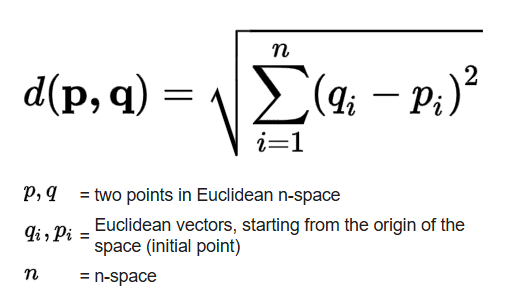

In [ ]:

def build_cell_to_cell_graph_normal():   
    outliers = []
    x = torch.tensor(gene_expression, dtype=torch.float32).unsqueeze(1)

    k = 2  
    distance_threshold = 500 
    distances = euclidean_distances(x, x)

    edge_index_list = []

    for i in range(len(cells)):
        nearest_neighbors = np.argsort(distances[i])[1:k+1]  
        for j in nearest_neighbors:
            if distances[i, j] <= distance_threshold:
                edge_index_list.append((i, j))
            else:
                outliers.append(int(j))

    edge_index_np = np.array(edge_index_list).T
    edge_index = torch.tensor(edge_index_np, dtype=torch.long) if edge_index_np.size > 0 else torch.empty((2, 0), dtype=torch.long)

    source_cells = cells[edge_index_np[0]]
    target_cells = cells[edge_index_np[1]]

    for src, tgt in zip(source_cells, target_cells):
        print(f"Cell {src} is connected to Cell {tgt}")

    #cleaned outliers
    cleaned_outliers = list(set(outliers))
    print(cleaned_outliers)
    
    #pyG data object
    data = Data(edge_index=edge_index, x=x)
    return data

data = build_cell_to_cell_graph_normal()

#### Testing similarity metric(Euclidean Distance) using FAISS and moving process load to GPU

Squared Euclidean distance (L2 norm squared)

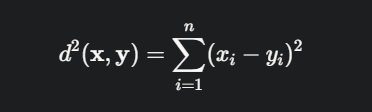

In [ ]:
def build_cell_to_cell_graph_faiss():

    x = np.asarray(gene_expression, dtype=np.float32)
    x = x.reshape(-1, 1) #reshape to 1D array

    gpu_resource_manager = faiss.StandardGpuResources() #this manages GPU resources
    similarity_object = faiss.IndexFlatL2(1) #object for fast smilarity search (1) set to one because of dimensions
    similarity_object_in_gpu = faiss.index_cpu_to_gpu(gpu_resource_manager, 0,similarity_object)

    similarity_object_in_gpu.add(x)
    k=2
    distances, indices = similarity_object_in_gpu.search(x, k + 1)
    
    # Process results
    edge_index_list = []
    outliers = []
    
    for i in range(len(cells)):
        # Skip the first neighbor (self)
        nearest_neighbors = indices[i, 1:k+1]  # Get k nearest excluding self
        neighbor_distances = distances[i, 1:k+1]
        
        for j, dist in zip(nearest_neighbors, neighbor_distances):
            if dist <= 500 ** 2:
                edge_index_list.append((i, j))
            else:
                outliers.append(int(j))
    
    # Convert edges to torch tensor
    edge_index_np = np.array(edge_index_list).T
    edge_index = torch.tensor(edge_index_np, dtype=torch.long) if edge_index_np.size > 0 else torch.empty((2, 0), dtype=torch.long)
    
    # Print connections
    source_cells = cells[edge_index_np[0]]
    target_cells = cells[edge_index_np[1]]
    for src, tgt in zip(source_cells, target_cells):
        print(f"Cell {src} is connected to Cell {tgt}")
    

    cleaned_outliers = list(set(outliers))
    print(cleaned_outliers)

    x_tensor = torch.tensor(x, dtype=torch.float32)
    pyg_data = Data(edge_index=edge_index, x=x_tensor)
    
    return pyg_data

build_cell_to_cell_graph_faiss()